In [14]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
import sys
path_to_project = ""

sys.path.append(path_to_project + "benchmark_VAE/")
sys.path.append(path_to_project + "benchmark_VAE/src/")

In [15]:
import pickle
from pythae.models import AutoModel
from pythae.ssc.plots import *
import random
import matplotlib.pyplot as plt
import numpy as np
import os
from pythae.ssc.results import EvalPatient, EvaluationDataset
from pythae.ssc.utils import load_cv, remove_short_samples

In [16]:
# adapt paths
data_path = path_to_project + "fake_data/processed/"
figure_path = path_to_project + "demo_notebooks/plots/"
model_path = (
    path_to_project + "demo_notebooks/saved_models/model_fold_0/"
)

name = "_ml4h"
with open(data_path + "bodies_" + name + ".pkl", "rb") as file:
    bodies = pickle.load(file)
with open(data_path + "cohorts_" + name + ".pkl", "rb") as file:
    cohorts = pickle.load(file)

In [17]:
# variables info
var_weights0 = [
    var.class_weight_norm for var in (bodies[0].variables + bodies[0].labels)
]
(
    data_train_folds,
    data_valid_folds,
    data_test_folds,
    varNames,
    varSplits,
    xyt0,
    xyt1,
) = load_cv(data_path, n_folds=2, name=name)
var_names0 = [var.name for var in (bodies[0].variables + bodies[0].labels)]

names_x0 = [vN for i, vN in enumerate(var_names0) if xyt0[i] == "x"]
names_y0 = [vN for i, vN in enumerate(var_names0) if xyt0[i] == "y"]
names_s0 = [vN for i, vN in enumerate(var_names0) if xyt0[i] == "s"]

kinds_x0 = [
    var.kind
    for var in (bodies[0].variables + bodies[0].labels)
    for nx in names_x0
    if var.name == nx
]
kinds_y0 = [
    var.kind
    for var in (bodies[0].variables + bodies[0].labels)
    for nx in names_y0
    if var.name == nx
]
splits_x0 = [vN for i, vN in enumerate(varSplits) if xyt0[i] == "x"]
splits_y0 = [vN for i, vN in enumerate(varSplits) if xyt0[i] == "y"]
splits_s0 = [vN for i, vN in enumerate(varSplits) if xyt0[i] == "s"]

names_x1 = [vN for i, vN in enumerate(varNames) if xyt1[i] == "x"]
kinds_x1 = [item for i, spl in enumerate(splits_x0) for item in [kinds_x0[i]] * spl]

In [18]:
# remove samples of length 0 or 1
for i, (data_train, data_valid, data_test) in enumerate(
    zip(data_train_folds, data_valid_folds, data_test_folds)
):
    data_train, data_valid, data_test = remove_short_samples(
        data_train, data_valid, data_test
    )

    data_train_folds[i] = data_train
    data_valid_folds[i] = data_valid
    data_test_folds[i] = data_test

In [19]:
last_training = sorted(os.listdir(model_path))[-1]
model = AutoModel.load_from_folder(
    os.path.join(model_path, last_training, "final_model")
)

In [20]:
# move to cpu
model.cpu()
model.device = "cpu"
model.classifiers = [classif.cpu() for classif in model.classifiers]
model.encoder.device = "cpu"
model.decoder.device = "cpu"
fold = 0
data_train = data_train_folds[fold]
data_valid = data_valid_folds[fold]
data_test = data_test_folds[fold]
body = bodies[fold]

In [21]:
eval_p = EvalPatient(
    data_test,
    model,
    body,
    splits_x0,
    names_x0,
    kinds_x0,
    splits_y0,
    names_y0,
    kinds_y0,
    names_s0,
    kinds_x1,
    names_x1,
    1,
    batch_num=random.choice(range(len(data_test))),
)

In [22]:
eval_p.evaluate()

Forced Vital Capacity (FVC - % predicted)


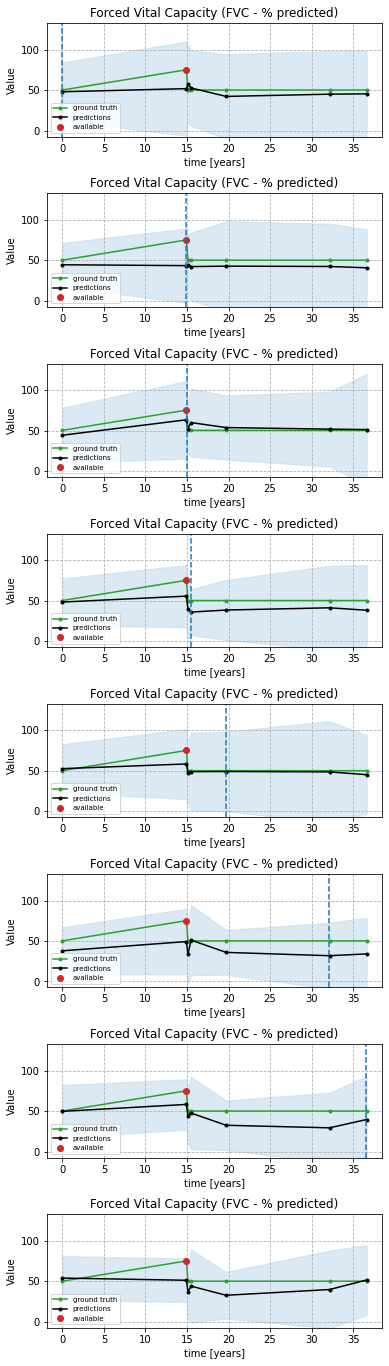

In [23]:
names_cont = [
    elem
    for index, elem in enumerate(names_x1)
    if kinds_x1[index] in ["continuous", "ordinal"]
]
for name in names_cont[:1]:
    print(name)
    eval_p.plot_continuous_feature(name, figure_path, plot_missing=True)

In [24]:
evaluation = EvaluationDataset(
    data_test,
    model,
    body,
    splits_x0,
    names_x0,
    kinds_x0,
    splits_y0,
    names_y0,
    kinds_y0,
    names_s0,
    kinds_x1,
    names_x1,
    len(data_test),
)
evaluation.evaluate(num_samples=10)

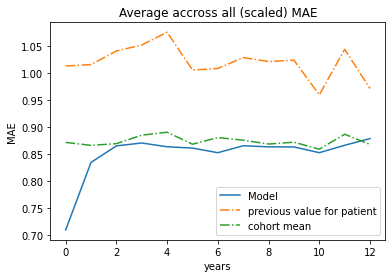

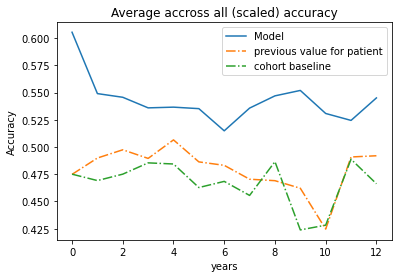

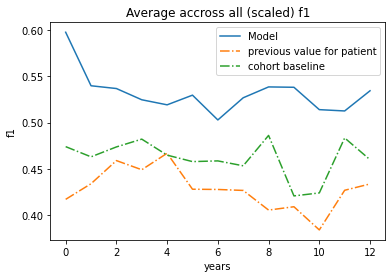

In [25]:
evaluation.get_patient_specific_baseline_x()
evaluation.get_result_df_x(verbose=False)

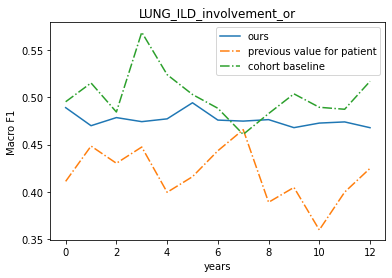

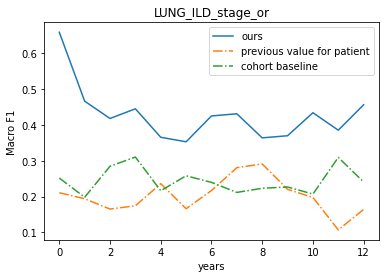

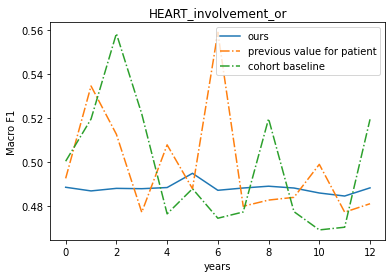

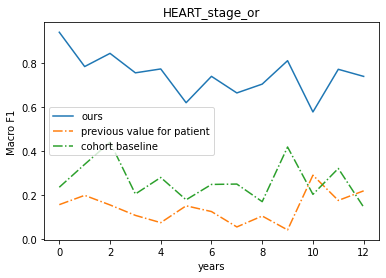

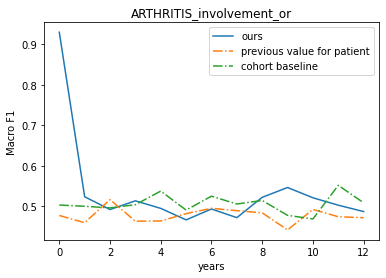

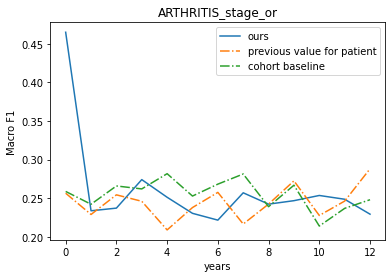

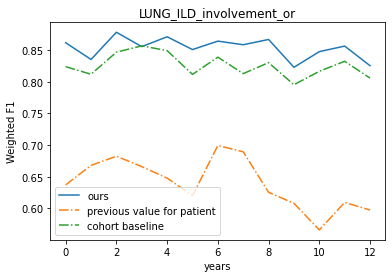

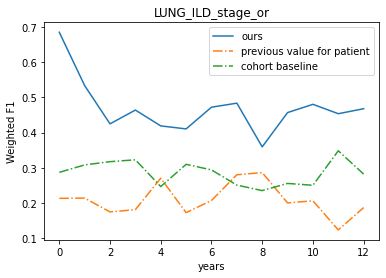

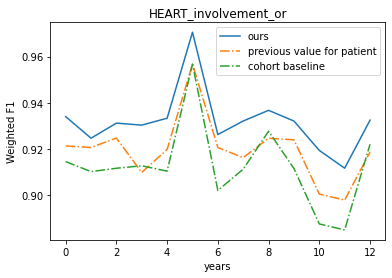

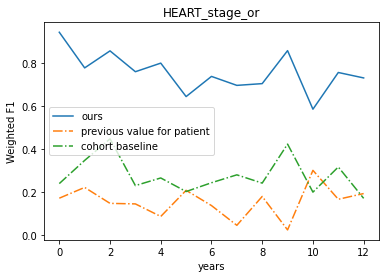

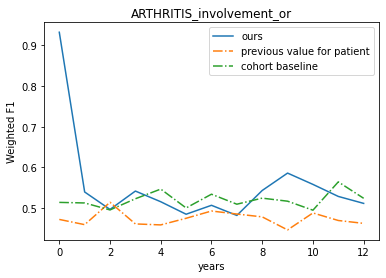

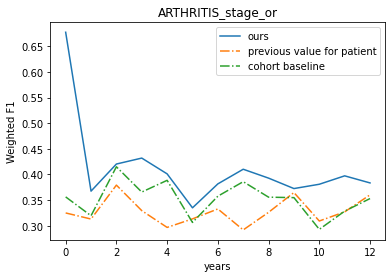

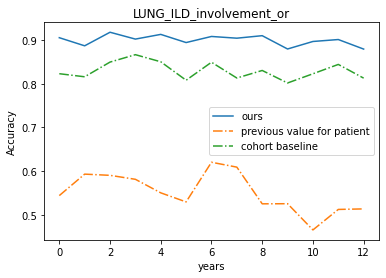

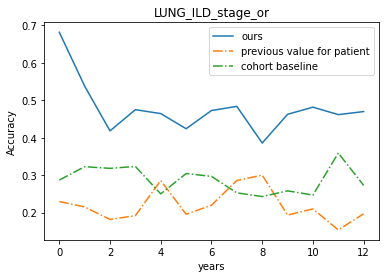

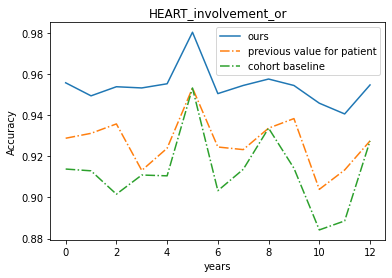

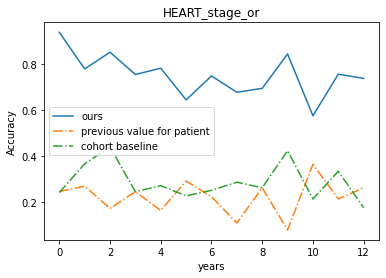

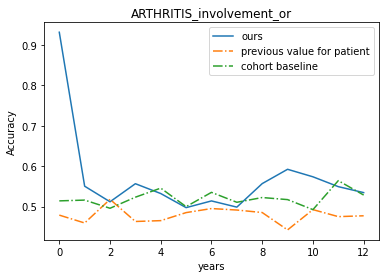

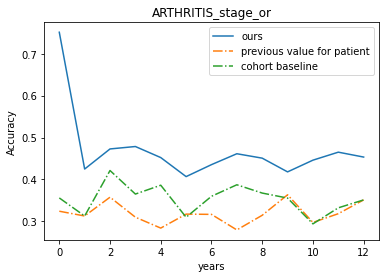

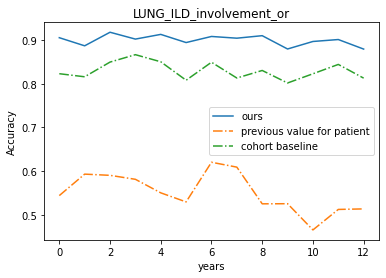

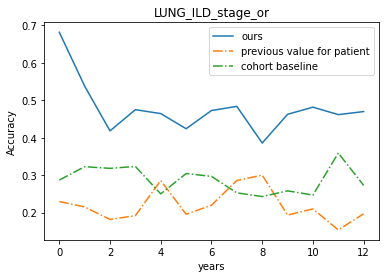

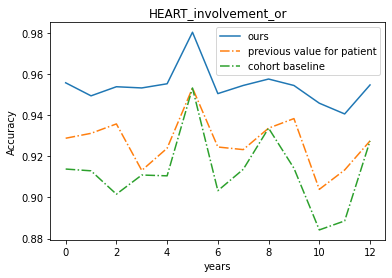

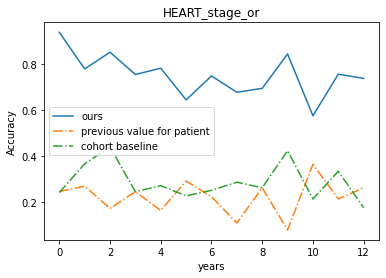

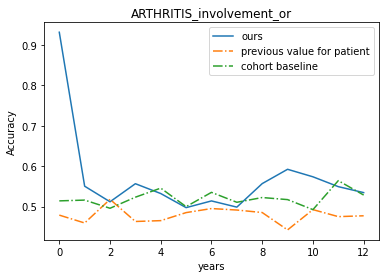

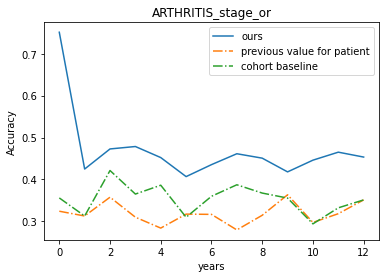

In [26]:
evaluation.get_patient_specific_baseline_y()
evaluation.get_result_df_y(verbose=False)